In [1]:
from netCDF4 import Dataset
import numpy as np
from sklearn.linear_model import LogisticRegression 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from pycurrents.codas import DB
import glob
import os

In [2]:
### Load in the training data. 
def nc_load(dir = "/home/jamie/cruise_processing/falkortoo/FKt240817/wh300/wh300.nc"):
    ### Load in the test data u and v for plotting. 
    file_id = Dataset(dir)
    u = file_id.variables["u"][:]
    pg = file_id.variables["pg"][:]
    amp = file_id.variables["amp"][:]
    mask = file_id.variables["pflag"][:]
    depth = file_id.variables["depth"][:]
    file_id.close()

    features = np.stack([amp.flatten(), depth.flatten(), pg.flatten()], axis=1)
    predictor =  mask.flatten()
    s = mask.shape
    # error velocity sounds nice too
    return(features, predictor, u, s)

# funtion for listing all nc files in a directory with there absolute path. 
def list_nc_files(directory):
    nc_files = glob.glob(os.path.join(directory, '**', '*.nc'), recursive=True)
    # Convert to absolute paths
    nc_files = [os.path.abspath(path) for path in nc_files]
    return nc_files

In [3]:
# load train data
# loop through the list using nc_loader and put output into an empty list then compress the list. 
ncfiles = list_nc_files("/home/jamie/projects/flag_model/data")
X = list()
Y = list()
for i in range(0, len(ncfiles)):
    file = ncfiles[i]
    param, predic, u, s = nc_load(file)
    X.append(param)
    Y.append(predic)
features = np.vstack(X)
predictor = np.hstack(Y)
# predictor = predictor.flatten()

In [4]:
# Only train on the good stuf. 
arg = [0, 1] #, 2, 3, 4, 5, 6, 7] #, 2, 6]
idx = np.isin(predictor, arg)
usr_mask = idx.flatten()
features = features[idx,:]
predictor = predictor[usr_mask]

# make all masks 0 or 1
# mask_train[mask_train != 0] = 1 

In [5]:
# run the model
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_features = scaler.fit_transform(train_cruise)
X_train, X_test, y_train, y_test = train_test_split(features, predictor, test_size=0.7, random_state=42, stratify=predictor)
model = LogisticRegression(max_iter=7000)  
model.fit(X_train, y_train)

In [ ]:
# laod test data
features_test, predictor_test, u,  s = nc_load("/home/jamie/cruise_processing/falkortoo/FKt240224/wh300_patch/contour/wh300.nc")
new_y_pred = model.predict(features_test) 
# put humpoty dumpty back together again
pred_flags = new_y_pred.reshape(s[0], s[1]) 
predictor_test = predictor_test.reshape(s[0], s[1]) 
# predictor_test[predictor_test != 0] = 1

In [ ]:
# Everything that isnt unflagged or manually flagged is now identified. 
auto_flagged = predictor_test.copy()
bin_flag = predictor_test.copy()

# subset only the algorithm falgs
arg = [0, 1]# , 2, 3, 4, 5, 6, 7] #, 2, 6]
idx = np.isin(predictor_test, arg)
auto_flagged[~idx] = 1
auto_flagged[idx] = 0

# subset only the manualy edited falgs
arg = [1]# , 2, 3, 4, 5, 6, 7] #, 2, 6]
idx = np.isin(predictor_test, arg)
bin_flag[~idx] = 0

# subset only the all the flags. 
all_flag = predictor_test.copy()
all_flag[all_flag != 0] = 1

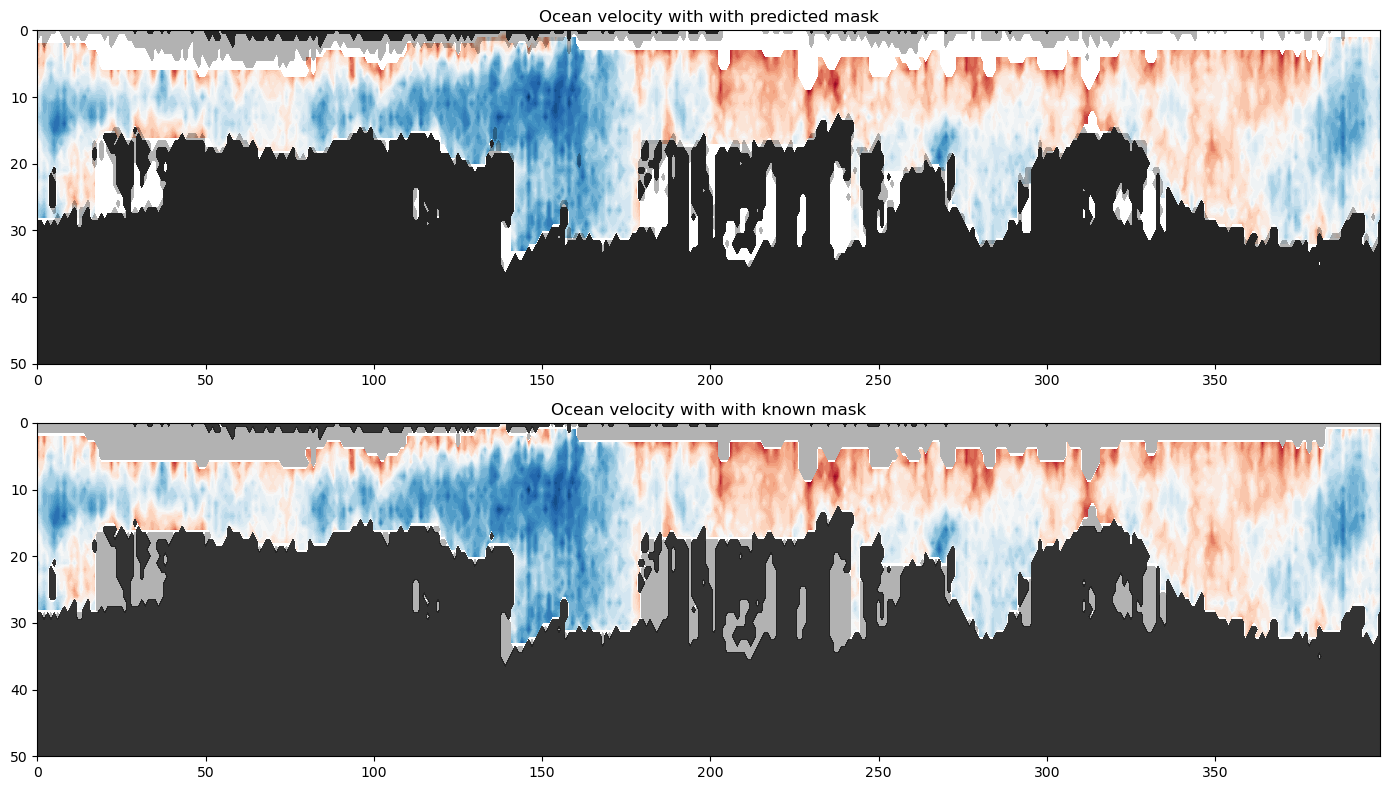

In [ ]:
idx = range(3400, 3800)

# Define the feature array and predicted mask array
feature = u # n by m array
predicted_mask = pred_flags  # n by m array

fig, ax = plt.subplots(2, 1, figsize=(14, 8))
contour1 = ax[0].contourf(feature.T[:, idx], cmap='RdBu', levels=50)
# contour1.set_clim(-0.4, 0.4)
# Overlay the predicted mask as a contour on top with transparency
ax[0].contourf(predicted_mask.T[:, idx], levels=[0.5, 1], colors='black', alpha=0.3)
ax[0].contourf(auto_flagged.T[:, idx], levels=[0.5, 1], colors='black', alpha=0.8)
ax[0].set_title('Ocean velocity with with predicted mask')
ax[0].set_ylim(50, 0)

contour2 = ax[1].contourf(feature.T[:, idx], cmap='RdBu',levels=50)
# contour2.set_clim(-0.4, 0.4)
# Overlay the predicted mask as a contour on top with transparency
ax[1].contourf(bin_flag.T[:, idx], levels=[0.5, 1], colors='black', alpha=0.3)
ax[1].contourf(auto_flagged.T[:, idx], levels=[0.5, 1], colors='black', alpha=0.8)
ax[1].set_title('Ocean velocity with with known mask')
ax[1].set_ylim(50, 0)
# fig.colorbar(contour2, ax=ax, orientation='vertical', label="ocean velocity")
plt.tight_layout()
plt.show()

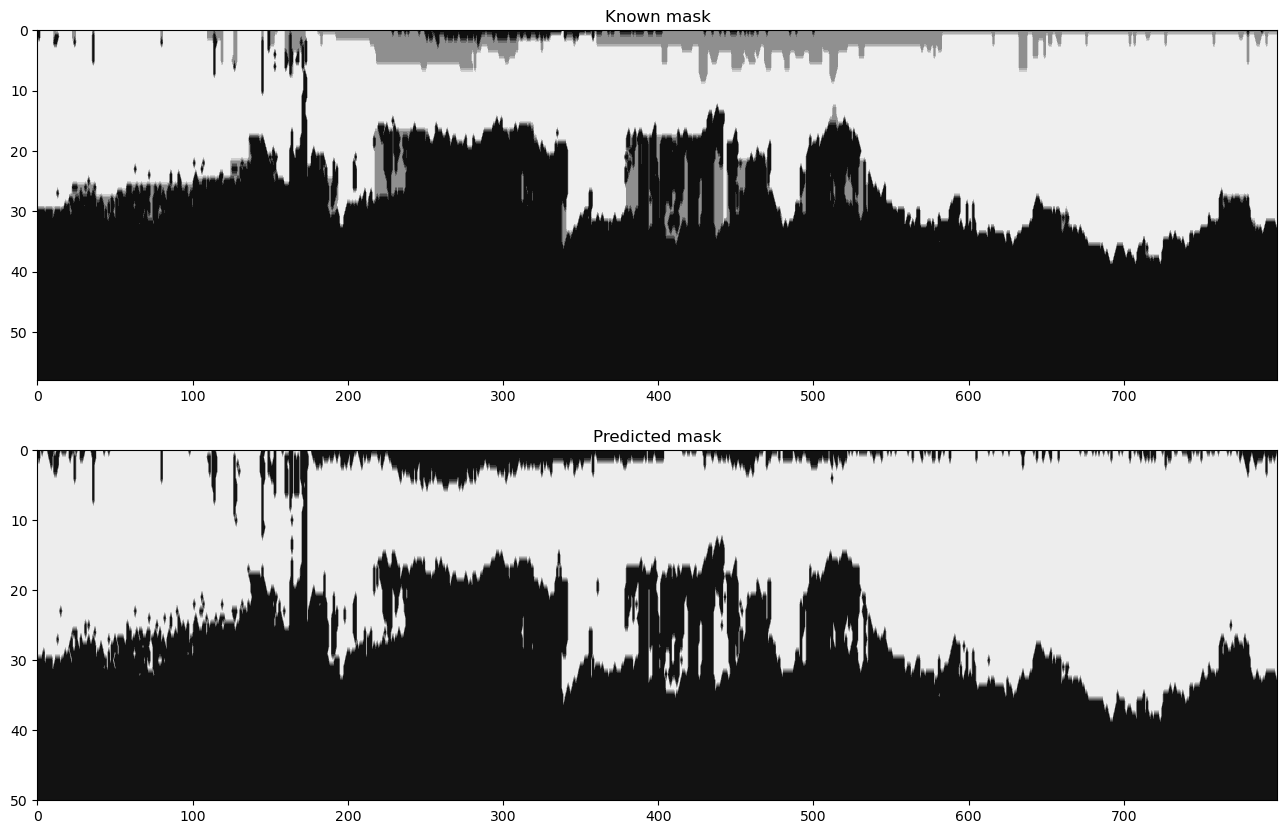

In [ ]:
idx = range(3200, 4000)

fig, ax = plt.subplots(2, 1, figsize = (16, 10))
ax[0].contourf(predictor_test.T[:, idx], cmap='binary') 
ax[0].set_ylim(58, 0)
ax[0].set_title('Known mask')
ax[1].contourf(pred_flags.T[:, idx], cmap='binary') 
ax[1].set_ylim(50, 0)
ax[1].set_title('Predicted mask');